In [1]:
import math
import jax
import jax.random as jrd
import jax.numpy as jnp
import numpy as np

from tqdm.auto import tqdm

In [2]:
def poisson_prob(n, lam):
    return math.e**(-lam) * (lam**n) / jax.scipy.special.factorial(n)

def get_poisson_probs(max_cars_to_rent: int, lam: int):
    print(type(max_cars_to_rent))
    probs = [poisson_prob(i, lam) for i in range(max_cars_to_rent)]
    probs.append(1 - sum(probs))
    return jnp.array(probs)


In [3]:
max_cars = 20

$V(s) = \sum_{(s',r)}{ p(s',r | s,a)[r + \gamma * V(s')] }$

$V(s) = \sum_{s',r}{ [p(r|s,a) \times r + p(r|s,a) \times \gamma V(s')]}$

$V(s) = \sum_r { p(r|s,a)*r } + \sum_{s'}{p(s'|s,a) \times \gamma V(s')}$

In [4]:
prob_requests_1 = get_poisson_probs(max_cars, 3)
prob_requests_2 = get_poisson_probs(max_cars, 4)

prob_returns_1 = get_poisson_probs(max_cars, 3)
prob_returns_2 = get_poisson_probs(max_cars, 2)    

<class 'int'>


W0113 01:28:28.303442  234678 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0113 01:28:28.306699  234604 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


<class 'int'>
<class 'int'>
<class 'int'>


In [5]:
# expected reward of starting with i cars
expected_reward_1 = np.zeros((max_cars+1), dtype=np.float32)
expected_reward_2 = np.zeros((max_cars+1), dtype=np.float32)

# prob of ending with j cars while starting with i:  prob[i,j]
probs_1 = np.zeros((max_cars+1, max_cars+1), dtype=np.float32)
probs_2 = np.zeros((max_cars+1, max_cars+1), dtype=np.float32)
for i in tqdm(range(max_cars+1)):
    for rented in range(max_cars+1):
        real_rented = min(i, rented)

        # exercise
        prob_rent_parking_1 = 0
        prob_rent_parking_2 = 0
        
        for returned in range(max_cars+1):

            j = i - real_rented + returned
            j = min(j, max_cars)
            
            probs_1[i][j] += prob_requests_1[rented] * prob_returns_1[returned]
            probs_2[i][j] += prob_requests_2[rented] * prob_returns_2[returned]


        expected_reward_1[i] += 10 * real_rented * prob_requests_1[rented]
        expected_reward_2[i] += 10 * real_rented * prob_requests_2[rented]



  0%|          | 0/21 [00:00<?, ?it/s]

In [6]:
# possible_actions = jnp.array(range(max_cars * 2 + 1), dtype=jnp.int16) - max_cars
possible_actions = jnp.arange(-5, 6)
print(possible_actions)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]


In [7]:
# initialization
state_values = jnp.zeros((max_cars+1, max_cars+1), dtype=jnp.float32)
policy = jnp.full((max_cars+1, max_cars+1), fill_value=20, dtype=jnp.int16)
print(policy)

[[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
 [20 20 20

In [8]:
jnp.arange(max_cars+1) - 0

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int32)

In [9]:
from itertools import count

for i in count():
    # step 2: policy evaluation
    I, J = jnp.meshgrid(jnp.arange(max_cars + 1), jnp.arange(max_cars + 1), indexing='ij')

    gamma = 0.9

    while True:
        delta = 0
        raw_actions = possible_actions[policy]
                
        pos_mask = raw_actions > 0
        valid_actions = jnp.where(pos_mask, jnp.minimum(raw_actions, I), raw_actions)
        
        neg_mask = raw_actions < 0
        valid_actions = jnp.where(neg_mask, jnp.maximum(valid_actions, -J), valid_actions)
        
        morning_1 = jnp.clip(I - valid_actions, 0, max_cars)
        morning_2 = jnp.clip(J + valid_actions, 0, max_cars)

        rent_rewards = expected_reward_1[morning_1] + expected_reward_2[morning_2]

        action_reward = -2 * jnp.abs(valid_actions)

        # exercise 
        free_move_reward = jnp.where(valid_actions > 0, 2, 0)
        parking_cost = 4 * ((morning_1 > 10) + (morning_2 > 10))

        R = rent_rewards + action_reward + free_move_reward - parking_cost


        expected_v_of_morning_state = probs_1 @ state_values @ probs_2.T
        expected_future_values = expected_v_of_morning_state[morning_1, morning_2]

        new_state_values = R + gamma * expected_future_values
        
        max_delta = jnp.max(jnp.abs(state_values - new_state_values))

        print("abs state values error =", jnp.mean(jnp.abs((state_values - new_state_values))))

        state_values = new_state_values
        if max_delta < 0.01:
            print(max_delta)
            break

    # step 3: policy improvement
    I_expanded = jnp.expand_dims(I, axis=-1)
    J_expanded = jnp.expand_dims(J, axis=-1)

    valid_actions = jnp.clip(possible_actions, -J_expanded, I_expanded)

    expected_future_val_grid = probs_1 @ state_values @ probs_2.T

    morning_1 = jnp.clip(I_expanded - valid_actions, 0, max_cars)
    morning_2 = jnp.clip(J_expanded + valid_actions, 0, max_cars)

    rent_rewards = expected_reward_1[morning_1] + expected_reward_2[morning_2]

    move_cost = 2 * jnp.abs(valid_actions)

    # exercise 
    free_move_reward = jnp.where(valid_actions > 0, 2, 0)
    parking_cost = 4 * ((morning_1 > 10) + (morning_2 > 10))

    next_state_values = expected_future_val_grid[morning_1, morning_2]

    expected_values = rent_rewards - move_cost + free_move_reward - parking_cost + gamma * next_state_values

    new_policy = jnp.argmax(expected_values, axis=2)

    policy_stable = jnp.all(new_policy == policy)
    total_diff_actions = jnp.sum(new_policy != policy)
    policy = new_policy
    print(i)
    print("total different actions =", total_diff_actions)

    if policy_stable:
        print("Optimal policy has been found")
        break


abs state values error = 48.69049
abs state values error = 38.616505
abs state values error = 30.340483
abs state values error = 25.172241
abs state values error = 22.122974
abs state values error = 19.827541
abs state values error = 17.827871
abs state values error = 16.03385
abs state values error = 14.431039
abs state values error = 12.977978
abs state values error = 11.684769
abs state values error = 10.512803
abs state values error = 9.460154
abs state values error = 8.510481
abs state values error = 7.6645994
abs state values error = 6.8916993
abs state values error = 6.2135124
abs state values error = 5.586867
abs state values error = 5.0217485
abs state values error = 4.514114
abs state values error = 4.061536
abs state values error = 3.6444194
abs state values error = 3.3021824
abs state values error = 2.9396992
abs state values error = 2.6792972
abs state values error = 2.4116728
abs state values error = 2.1734405
abs state values error = 1.9518299
abs state values error = 1.

In [10]:
state_values.shape

(21, 21)

In [11]:
jnp.array(state_values, dtype=jnp.int32)

Array([[430, 439, 449, 459, 468, 477, 485, 493, 500, 508, 515, 522, 528,
        535, 540, 545, 547, 552, 556, 560, 563],
       [439, 449, 459, 469, 478, 486, 495, 502, 510, 517, 524, 530, 537,
        542, 547, 551, 554, 558, 562, 565, 569],
       [449, 459, 469, 478, 487, 496, 504, 512, 519, 526, 532, 539, 544,
        549, 553, 557, 560, 564, 567, 571, 574],
       [459, 469, 478, 487, 496, 505, 513, 521, 528, 534, 541, 546, 551,
        555, 559, 562, 566, 569, 573, 576, 579],
       [468, 478, 487, 496, 505, 513, 521, 529, 536, 542, 548, 553, 557,
        561, 564, 568, 571, 575, 578, 581, 584],
       [476, 486, 496, 505, 513, 521, 529, 536, 543, 549, 555, 559, 563,
        566, 570, 573, 577, 580, 583, 586, 588],
       [484, 494, 503, 512, 521, 529, 536, 543, 550, 556, 561, 565, 568,
        571, 575, 578, 582, 585, 588, 590, 592],
       [492, 501, 511, 520, 528, 536, 543, 550, 556, 562, 567, 570, 573,
        576, 580, 583, 586, 589, 592, 594, 596],
       [499, 509, 518, 5

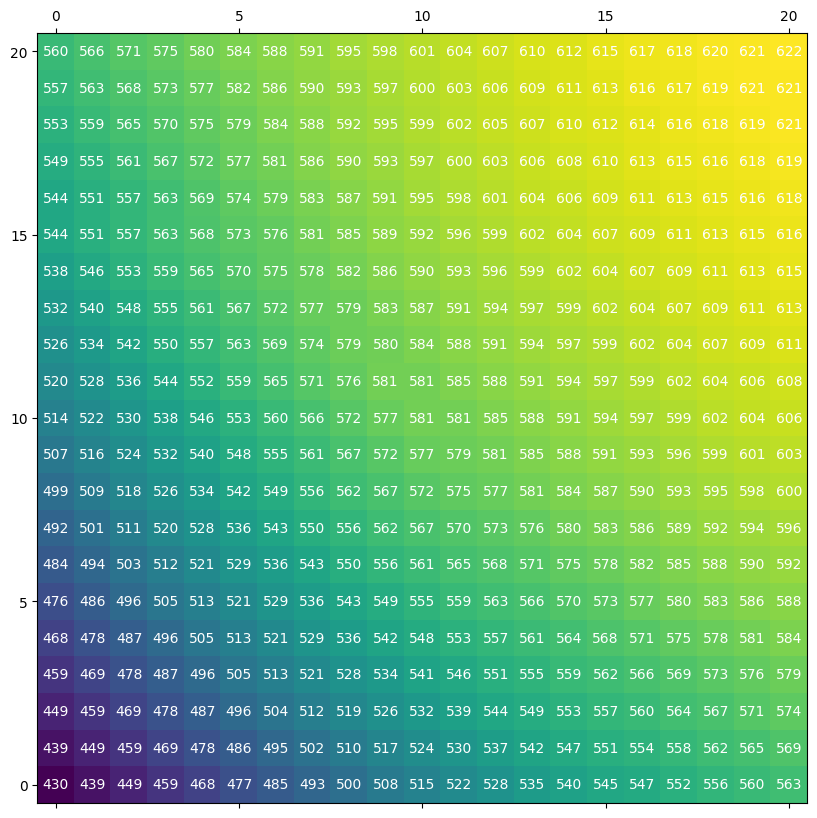

In [12]:
import matplotlib.pyplot as plt

round_state_values = jnp.array(state_values, dtype=jnp.int32)

fig, ax = plt.subplots(figsize=(10, 10))

ax.matshow(round_state_values, cmap='viridis') # Using a colormap for better visual distinction

ax.invert_yaxis()

for (i, j), z in np.ndenumerate(round_state_values):
    ax.text(j, i, f'{z}', ha='center', va='center', color='white') 

plt.show()


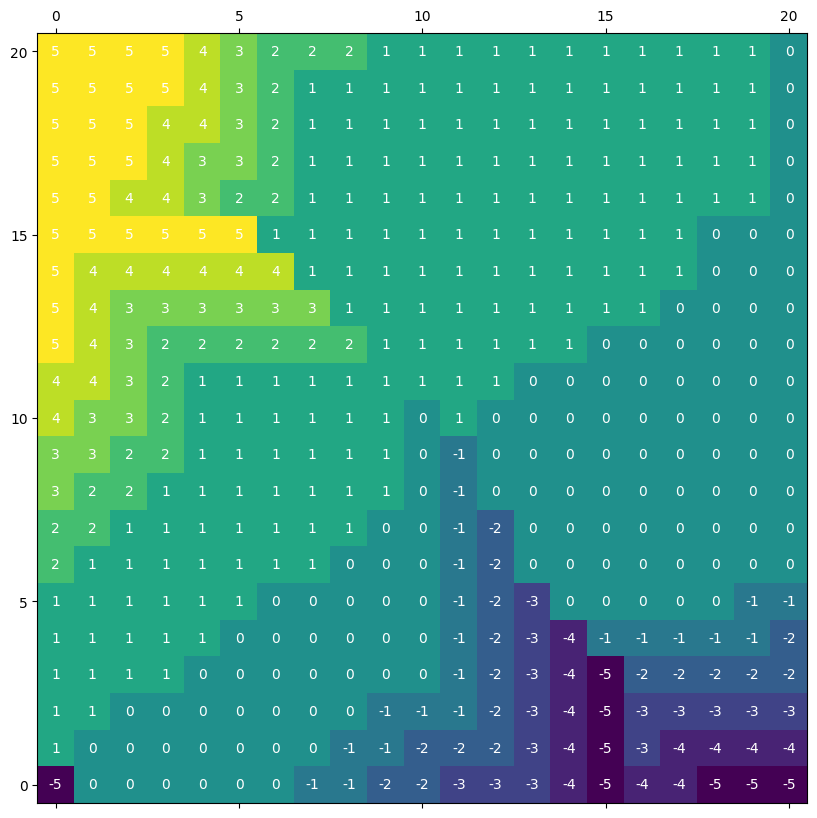

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

ax.matshow(possible_actions[policy], cmap='viridis') # Using a colormap for better visual distinction

ax.invert_yaxis()

for (i, j), z in np.ndenumerate(possible_actions[policy]):
    ax.text(j, i, f'{z}', ha='center', va='center', color='white') 

plt.show()
